# 05-22 Homework

In [22]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import sklearn.model_selection as skm
from ISLP import load_data, confusion_table
from ISLP.models import ModelSpec as MS

In [23]:
from sklearn.tree import (DecisionTreeClassifier as DTC, #calssification tree
                          DecisionTreeRegressor as DTR,  #regression tree
                          plot_tree,
                          export_text)
from sklearn.metrics import (accuracy_score,
                             log_loss)
from ISLP.bart import BART

## 2. Regression Tree

In [24]:
Carseats = load_data('Carseats') #ISLP

In [25]:
model = MS(Carseats.columns.drop('Sales'), intercept=False) # 不包含常數項
D = model.fit_transform(Carseats)
feature_names = list(D.columns)
X = np.asarray(D)

In [26]:
(X_train,
 X_test,
 y_train,
 y_test) = skm.train_test_split(X,
                                   Carseats['Sales'],
                                   test_size=0.5,
                                   random_state=0)

In [27]:
reg = DTR(random_state =0) #tunning parameters


In [28]:
ccp_path = reg.cost_complexity_pruning_path(X_train, y_train)
kfold = skm.KFold(10,           # 5-fold CV
                  shuffle=True, # 分群時打亂資料
                  random_state=1) #設定 seed
grid = skm.GridSearchCV(reg,
                        {'ccp_alpha': ccp_path.ccp_alphas}, #目標參數: Effective alphas of subtree during pruning.
                        refit=True, #Refit an estimator using the best found parameters on the whole dataset
                        cv=kfold,   #cv分法
                        scoring='neg_mean_squared_error') #透過呼叫sklearn.metrics下的 mean_absolute_error() 來進行計算
G = grid.fit(X_train, y_train)

### a. Regression tree 圖形

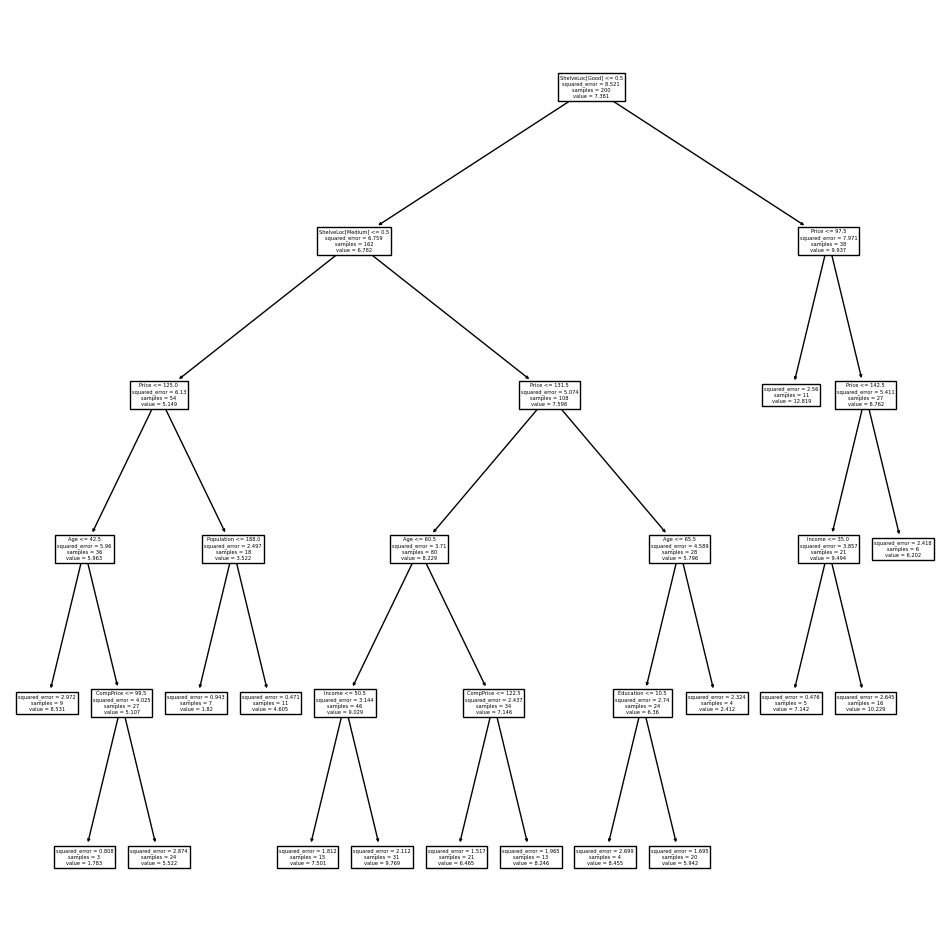

In [29]:
ax = subplots(figsize=(12,12))[1]
plot_tree(G.best_estimator_,
          feature_names=feature_names,
          ax=ax);

### b. test set 的 MSE 

In [30]:
best_ = grid.best_estimator_
np.mean((y_test - best_.predict(X_test))**2)

5.317061913597124

MSE 為 5.317

### C. 和 classification tree 結果做比較

In [31]:
High_test = np.where(y_test > 8, # response: classification tree, 定義 binary outcome
                "Yes",
                "No")
High_pred = np.where(best_.predict(X_test) > 8, # response: classification tree, 定義 binary outcome
                "Yes",
                "No")

In [32]:
print(accuracy_score(High_test,
                     High_pred))
confusion = confusion_table(High_pred,
                            High_test)
confusion

0.7


Truth,No,Yes
Predicted,,
No,81,23
Yes,37,59


和 classification tree 的結果比起來，正確率稍低 (0.7<0.72)

## 3. Classification tree homework

In [33]:
Boston = load_data("Boston")
model = MS(Boston.columns.drop('medv'), intercept=False) # 不包含常數項
D = model.fit_transform(Boston)
feature_names = list(D.columns)
X = np.asarray(D)

In [34]:
High = np.where(Boston.medv > 25, # response: classification tree, 定義 binary outcome
                "Yes",
                "No")

In [35]:
(X_train,
 X_test,
 High_train,
 High_test) = skm.train_test_split(X,
                                   High,
                                   test_size=0.7,
                                   random_state=0)

In [36]:
clf = DTC(criterion='gini', max_depth=3, random_state=0)
ccp_path = clf.cost_complexity_pruning_path(X_train, High_train)
kfold = skm.KFold(5,
                  random_state=10,
                  shuffle=True)

In [37]:
grid = skm.GridSearchCV(clf,
                        {'ccp_alpha': ccp_path.ccp_alphas},
                        refit=True,
                        cv=kfold,
                        scoring='accuracy')
grid.fit(X_train, High_train)
#?skm.GridSearchCV
grid.best_score_

0.913978494623656

### a. Classification tree 的圖形

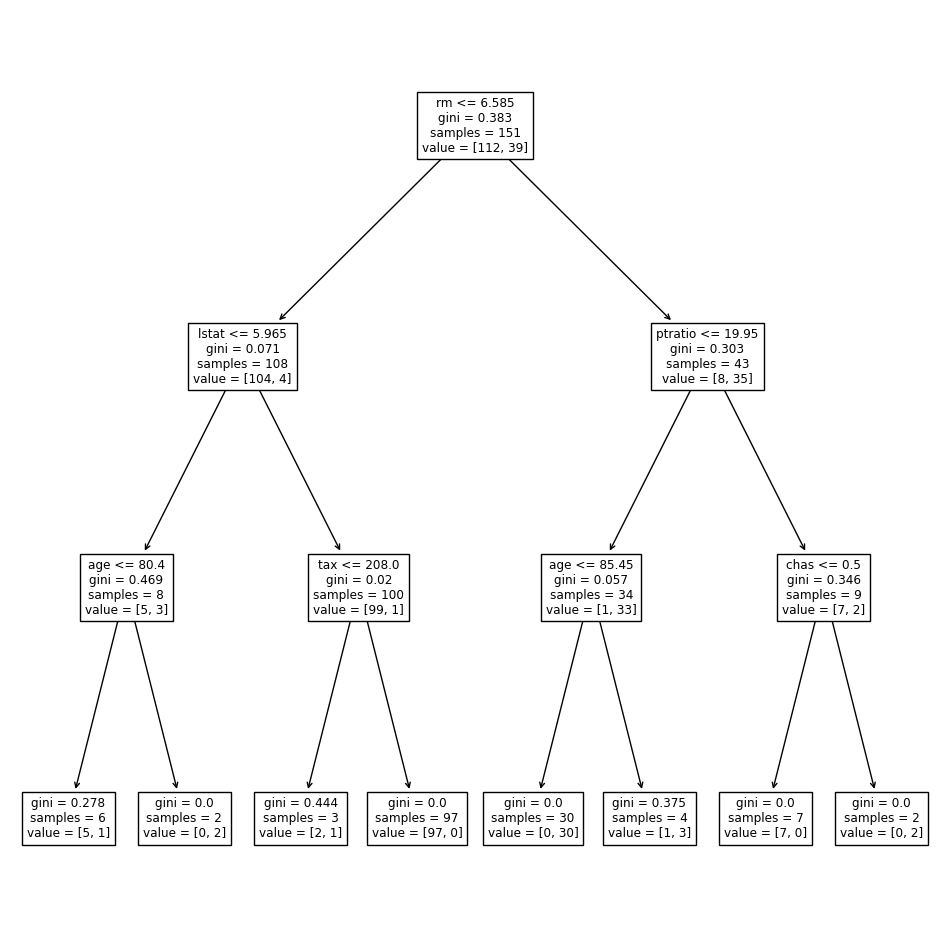

In [38]:
ax = subplots(figsize=(12, 12))[1]
best_ = grid.best_estimator_
plot_tree(best_,
          feature_names=feature_names,
          ax=ax);

### b. 用 test set 算出的模型預測正確率，以及 confusion matrix。

In [39]:
print(accuracy_score(High_test,
                     best_.predict(X_test)))
confusion = confusion_table(best_.predict(X_test),
                            High_test)
confusion

0.9126760563380282


Truth,No,Yes
Predicted,,
No,259,20
Yes,11,65
